### Import Necessary Module and Set Path 

In [2]:
import sqlite3 as lite
import os
import sys
import numpy as np
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()

In [3]:
import analysis as an

## Run Cyclus Input file

In [3]:
! rm just_france.sqlite
! cyclus just_france.xml -o just_france.sqlite

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

### The output file should be named 
         
          just_france.sqlite

In [80]:
# get sqlite cursor and simulation time data
cur = an.cursor('just_france.sqlite')
init_year, init_month, duration, timestep = an.simulation_timesteps(cur)

In [81]:
# get number of reactors and capacity timeseries
an.plot_power(cur)

french_facilities has no values
Sink_Source_Inst has no values
french_facilities has no values
Sink_Source_Inst has no values


In [82]:
# just france

parentid = cur.execute('SELECT agentid FROM agententry WHERE '
                       'Prototype LIKE "%france%" '
                       'AND Kind = "Inst"').fetchone()
entry_exit = cur.execute('SELECT max(value), timeseriespower.agentid, '
                         'parentid, entertime, prototype, entertime + lifetime'
                         ' FROM agententry '
                         'INNER JOIN timeseriespower '
                         'ON agententry.agentid = timeseriespower.agentid '
                         'WHERE parentid = %i '
                         'GROUP BY timeseriespower.agentid' %parentid[0]).fetchall()

init_year, init_month, duration, timestep = an.simulation_timesteps(cur)
dictionary = {}
lwr_cap = 0
astrid_cap = 0
dictionary['lwr'] = []
dictionary['astrid'] = []
for t in timestep:
    for agent in entry_exit:
        if (agent['entertime'] == t) and agent['prototype'] == 'astrid':
            astrid_cap += agent['max(value)'] * 0.001
        if (agent['entertime'] == t) and agent['prototype'] != 'astrid':
            lwr_cap += agent['max(value)'] * 0.001
        
        if (agent['entertime + lifetime'] == t) and agent['prototype'] == 'astrid':
            astrid_cap -= agent['max(value)'] * 0.001
        if (agent['entertime + lifetime'] == t) and agent['prototype'] != 'astrid':
            lwr_cap -= agent['max(value)'] * 0.001
    dictionary['lwr'].append(lwr_cap)
    dictionary['astrid'].append(astrid_cap)

an.stacked_bar_chart(dictionary, timestep,
                  'Years', 'Net_Capacity [GWe]',
                  'Net Capacity vs Time',
                  'france_power_plot', init_year)
            

In [60]:
# astrid deployment number per timestep
parentid = cur.execute('SELECT agentid FROM agententry WHERE '
                       'Prototype LIKE "%france%" '
                       'AND Kind = "Inst"').fetchone()
entry_exit = cur.execute('SELECT max(value), timeseriespower.agentid, '
                         'parentid, entertime, prototype, entertime + lifetime'
                         ' FROM agententry '
                         'INNER JOIN timeseriespower '
                         'ON agententry.agentid = timeseriespower.agentid '
                         'WHERE parentid = %i '
                         'GROUP BY timeseriespower.agentid' %parentid[0]).fetchall()

init_year, init_month, duration, timestep = an.simulation_timesteps(cur)
dictionary = {}

cum_dict = {}
num_dict = {}
cum_dict['cum'] = []
num_dict['num'] = []
astrid_cum = 0
for t in timestep:
    astrid_num = 0
    for agent in entry_exit:
        if (agent['entertime'] == t) and agent['prototype'] == 'astrid':
            astrid_num += 1
            astrid_cum += 1
        
        if (agent['entertime + lifetime'] == t) and agent['prototype'] == 'astrid':
            astrid_cum -= 1

    cum_dict['cum'].append(astrid_cum)
    num_dict['num'].append(astrid_num)

an.double_axis_bar_line_plot(num_dict, cum_dict, timestep,
                             'Years', 'Number of SFRs Deployed', ' Number of SFRs Operational',
                             'Build number and cumulative ASTRID Number vs Time', 'sfr_deploy.png',
                             init_year)

In [61]:
# Pu Composition in Spent Fuels:
pu_frac_spent_uox = cur.execute('SELECT sum(massfrac) FROM recipes LEFT OUTER JOIN compositions ON '
                'compositions.qualid = recipes.qualid '
                'WHERE recipe = "uox_used_fuel_recipe" '
                'and (nucid > 940000000 and nucid < 950000000)').fetchone()
pu_frac_spent_astrid = cur.execute('SELECT sum(massfrac) FROM recipes LEFT OUTER JOIN compositions ON '
                'compositions.qualid = recipes.qualid '
                'WHERE recipe = "sfr_spent_mox_recipe" '
                'and (nucid > 940000000 and nucid < 950000000)').fetchone()
print(pu_frac_spent_uox[0])
print(pu_frac_spent_astrid[0])

0.01188489984729947
0.27431405161777184


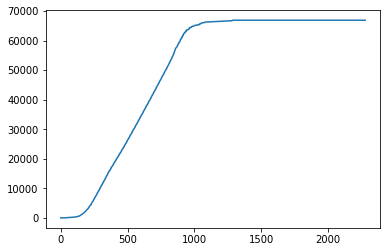

66857.18400000001


In [72]:
# Fuel Used
import matplotlib.pyplot as plt
agentids = an.agent_ids(cur, 'Reactor')
fuel_out = an.facility_commodity_flux(cur, agentids, ['french_uox_waste'],
                                      True, True)
plt.plot(fuel_out['french_uox_waste'])
plt.show()
print(fuel_out['french_uox_waste'][-1])


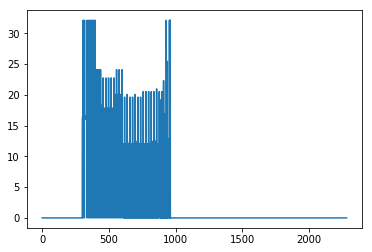

0.0


In [63]:
# mox used
agentids = an.agent_ids(cur, 'Reactor')
mox_in = an.facility_commodity_flux(cur, agentids, ['mox'],
                                   False, False)
plt.plot(mox_in['mox'])
plt.show()
print(mox_in['mox'][-1])

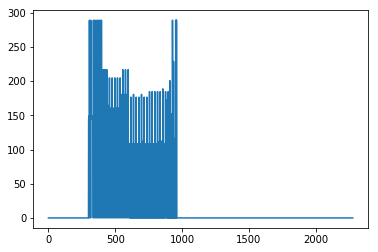

0.0


In [64]:
# lwr unf reprocessed

lwr_unf_reprocessed = np.array(mox_in['mox']) * 0.09 / 0.01
plt.plot(lwr_unf_reprocessed)
plt.show()

print(lwr_unf_reprocessed[-1])

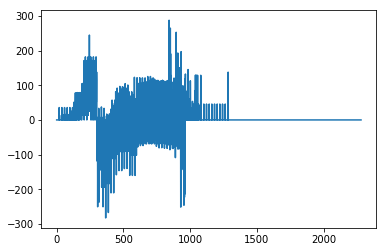

0.0


In [65]:
leftover = np.array(fuel_out['french_uox_waste']) - lwr_unf_reprocessed
plt.plot(leftover)
plt.show()
print(leftover[-1])

# Compares the fuel supply for just france vs all EU scenario

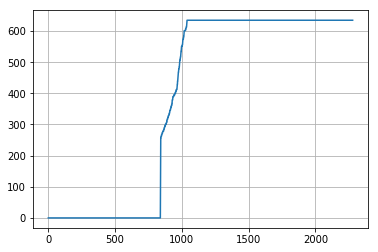

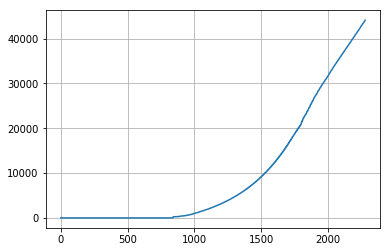

In [5]:
# just france
import matplotlib.pyplot as plt
cur = an.cursor('just_france.sqlite')
agentid = an.agent_ids(cur, 'Reactor')
just_france = an.facility_commodity_flux(cur, agentid, ['astrid_fuel_legacy', 'astrid_fuel_new'],
                                        False, True)
just_france_all_fuel = [x+y for x,y in zip(just_france['astrid_fuel_legacy'], just_france['astrid_fuel_new'])]
plt.plot(just_france['astrid_fuel_legacy'])
plt.grid()
plt.show()

plt.plot([x+y for x,y in zip(just_france['astrid_fuel_legacy'], just_france['astrid_fuel_new'])])
plt.grid()
plt.show()


In [6]:
# get sqlite cursor and simulation time data
cur = an.cursor('default_input_file.sqlite')
init_year, init_month, duration, timestep = an.simulation_timesteps(cur)

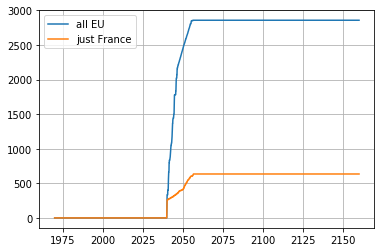

TypeError: unsupported operand type(s) for +: 'Rectangle' and 'float'

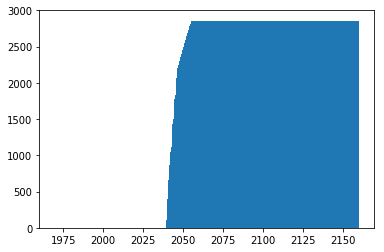

In [9]:
# all EU
agentid = an.agent_ids(cur, 'Reactor')
all_eu= an.facility_commodity_flux(cur, agentid, ['astrid_fuel_legacy', 'astrid_fuel_new'],
                                        False, True)
all_eu_all_fuel = [x+y for x,y in zip(all_eu['astrid_fuel_legacy'], all_eu['astrid_fuel_new'])]

years = init_year + timestep/12
plt.plot(years, all_eu['astrid_fuel_legacy'], label='all EU')
plt.plot(years, just_france['astrid_fuel_legacy'], label='just France')
plt.grid()
plt.legend()
plt.show()


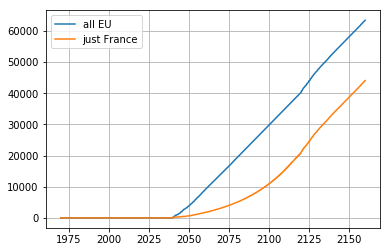

In [13]:
plt.plot(years, all_eu_all_fuel, label='all EU')
plt.plot(years, just_france_all_fuel, label='just France')
plt.grid()
plt.legend()
plt.show()

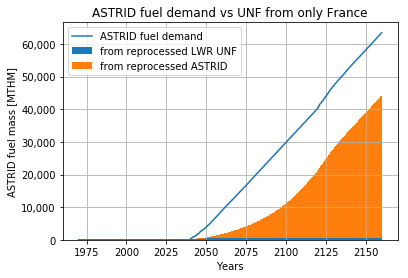

In [18]:
z1 = plt.bar(years, just_france['astrid_fuel_legacy'], label='from reprocessed LWR UNF')
z2 = plt.bar(years, just_france['astrid_fuel_new'], bottom=just_france['astrid_fuel_legacy'], label='from reprocessed ASTRID')
z3 = plt.plot(years, all_eu_all_fuel, label='ASTRID fuel demand')
plots = [z1, z2, z3]

ax = plt.gca()
ax.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

axes = plt.gca()
#plt.plot(years, all_eu_all_fuel, label='ASTRID Fuel Demand')
#plt.plot(years, just_france_all_fuel, label='Without EU LWR UNF')
plt.xlabel('Years')
plt.ylabel('ASTRID fuel mass [MTHM]')
plt.title('ASTRID fuel demand vs UNF from only France')
plt.grid()
plt.legend()
plt.savefig('france_only_compare.png', format='png', bbox_inches='tight')
plt.show()
plt.close()


In [ ]:
# pu to make astrid fuel
pu = np.array(astrid_get['astrid_fuel_legacy']) * 0.22
lwr_reprocessed = pu / 0.01
plt.plot(lwr_reprocessed)
plt.show()
print(lwr_reprocessed[-1])

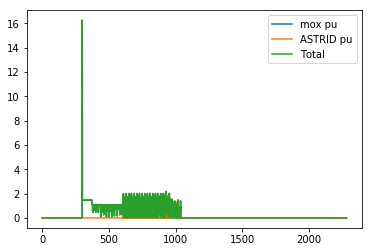

In [68]:
# pus

mixer = an.agent_ids(cur, 'Mixer')
pu = an.facility_commodity_flux(cur, mixer, ['french_uox_Pu', 'uox_Pu', 'astrid_Pu'],
                                False, False)
plt.plot(pu['french_uox_Pu'], label='mox pu')
plt.plot(pu['uox_Pu'], label='ASTRID pu')
plt.plot([x+y for x,y in zip(pu['french_uox_Pu'], pu['uox_Pu'])], label='Total')
plt.legend()
plt.show()


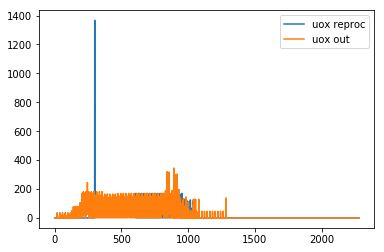

In [69]:
lwr_unf_reproc = np.array([x+y for x,y in zip(pu['french_uox_Pu'], pu['uox_Pu'])])
lwr_unf_reproc = lwr_unf_reproc / pu_frac_spent_uox[0]

plt.plot(lwr_unf_reproc, label='uox reproc')
plt.plot(fuel_out['french_uox_waste'], label='uox out')
plt.legend()
plt.show()

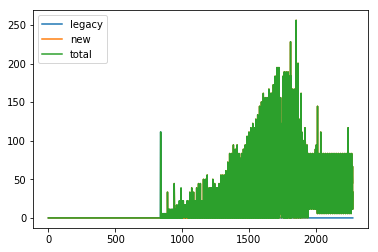

In [70]:
astridz = an.agent_ids(cur, 'Reactor')
fuelin = an.facility_commodity_flux(cur, astridz, ['astrid_fuel_legacy', 'astrid_fuel_new'],
                                    False, False)
plt.plot(fuelin['astrid_fuel_legacy'], label='legacy')
plt.plot(fuelin['astrid_fuel_new'], label='new')
plt.plot([x+y for x,y in zip(fuelin['astrid_fuel_legacy'], fuelin['astrid_fuel_new'])], label='total')
plt.legend()
plt.show()

In [71]:
# French UOX UNF total, in sink, and reprocessed
agent_ids = an.get_agent_ids(cur, 'Reactor')
french = an.facility_commodity_flux(cur, agent_ids, ['french_uox_waste'], True, True)
print('French UNF UOX total in 2050: %f' %french['french_uox_waste'][960])

agent_ids = an.get_prototype_id(cur, 'LA_HAGUE')
french_rep = an.facility_commodity_flux(cur, agent_ids, ['cooled_french_uox_waste'], False, True)
print('French UNF reprocesed up until 2050: %f' %french_rep['cooled_french_uox_waste'][960])


unused = french['french_uox_waste'][960] - french_rep['cooled_french_uox_waste'][960]
print('French UNF UOX unused in 2050: %f' %unused)

#french['in_sink'] = [x - y for x, y in zip(french['french_uox_waste'], french_rep['cooled_french_uox_waste'])] 
#print('French SNF in Sink')
#print(sum(french['in_sink']))


total_uox_unf = total + unused

print('Total UOX UNF available for Rerprocessing in 2050:%f' %total_uox_unf)

AttributeError: module 'analysis' has no attribute 'get_agent_ids'

In [ ]:
# plutonium from UNF inventory
pu_iso_list = [238, 239, 240, 241, 242]
mass_frac_list = [0.0001, 0.00518, 0.00232, 0.00126, 0.000487]
for i in range(5):
    print('Pu-%i has mass fraction of %f - %f tonnes available from 2050 UNF' %(pu_iso_list[i], mass_frac_list[i], mass_frac_list[i] * total_uox_unf))
print('Total: %f - %f tonnes available ' %(sum(mass_frac_list), sum(mass_frac_list) * total_uox_unf))


In [ ]:
# MOX usage to ASTRID
agent_ids = an.get_agent_ids(cur, 'Reactor')
french = an.facility_commodity_flux(cur, agent_ids, ['astrid_fuel_legacy', 'astrid_fuel_new'], False, True)
fuel_usage = [x+y for x,y in zip(french['astrid_fuel_legacy'], french['astrid_fuel_new'])]
print('Total ASTIRD MOX Loaded: %f' %max(fuel_usage))

dep_u = [x * 0.78 for x in fuel_usage]
print('Total Dep U Usage for production of ASTRID MOX:%f' %max(dep_u))


In [ ]:
# Average UOX reprocessing
agent_ids = an.get_prototype_id(cur, 'uox_reprocessing')
uox_pu_throughput = an.facility_commodity_flux(cur, agent_ids, ['uox_Pu'], True, False)
uox_reprocess_throughput = np.array([x / pu_frac_spent_uox[0] for x in uox_pu_throughput['uox_Pu']])
# start is the time 
start = uox_reprocess_throughput.nonzero()[0][0]
end = uox_reprocess_throughput.nonzero()[0][-1]
print(start)
print(end)
print('Average UOX Reprocessing Throughput is : %f' %uox_reprocess_throughput[start:end].mean())

In [ ]:
# Average ASTRID Reprocessing
agent_ids = an.get_prototype_id(cur, 'astrid_reprocessing')
astrid_pu_throughput = an.facility_commodity_flux(cur, agent_ids, ['astrid_Pu'], True, False)
astrid_reprocess_throughput = np.array([x / pu_frac_spent_astrid[0] for x in astrid_pu_throughput['astrid_Pu']])
# start is the time
start = astrid_reprocess_throughput.nonzero()[0][0]
end = astrid_reprocess_throughput.nonzero()[0][-1]
print('Average ASTRID Reprocessing Throughput is : %f' %astrid_reprocess_throughput[start:end].mean())

In [ ]:
# Average Total Reprocessing
total_reprocess_throughput = astrid_reprocess_throughput + uox_reprocess_throughput
start = uox_reprocess_throughput.nonzero()[0][0]
end = astrid_reprocess_throughput.nonzero()[0][-1]
print('Average total reprocessing throughput is: %f' %total_reprocess_throughput[start:end].mean())

In [ ]:
# Average fuel fabrication

agent_id = an.get_prototype_id(cur, 'astrid_mixer_uox')
agent_id2 = an.get_prototype_id(cur, 'astrid_mixer_astrid')
agent_ids = [agent_id[0], agent_id2[0]]

fab_throughput = an.facility_commodity_flux(cur, agent_ids, ['astrid_fuel_legacy', 'astrid_fuel_new'], True, False)
total_fab = np.array([x + y for x, y in zip(fab_throughput['astrid_fuel_legacy'], fab_throughput['astrid_fuel_new'])])
average_fab = total_fab[total_fab.nonzero()].mean()
print('Average ASTRID MOX fabrication throuhgput: %f' %average_fab)


In [ ]:
# Total Pu Reprocessed
pu_throughput = sum([x+y for x,y in zip(uox_pu_throughput['uox_Pu'], astrid_pu_throughput['astrid_Pu'])])
print('Total Pu reprocessed: %f' %pu_throughput)

In [ ]:
# Total ASTRID from UOX Waste
agent_ids = an.get_agent_ids(cur, 'Reactor')
astrid_fuel = an.facility_commodity_flux(cur, agent_ids, ['astrid_fuel_legacy','astrid_fuel_new'], False, True)
print('ASTRID fuel from UOX Waste: %f' %max(astrid_fuel['astrid_fuel_legacy']))
print('ASTRID fuel from ASTRID Waste: %f' %max(astrid_fuel['astrid_fuel_new']))

In [ ]:
# Total Legacy UNF Reprocessed:
total_legacy_unf = max(astrid_fuel['astrid_fuel_legacy']) * .22 / pu_frac_spent_uox[0]
print('Total legacy UNF reprocessed: %f' %total_legacy_unf)

In [ ]:
# Total reprocessed U stockpile
agent_ids = an.get_agent_ids(cur, 'Sink')
repu = an.facility_commodity_flux(cur, agent_ids, ['uox_U', 'astrid_U'], False, True)
total_repu = [x+y for x,y in zip(repu['uox_U'], repu['astrid_U'])]
print('Total reprocessed uranium stockpile: %f' %max(total_repu))

In [ ]:
# Total Raffinate
raff = an.facility_commodity_flux(cur, agent_ids, ['uox_raffinate', 'astrid_raffinate', 'lahague_raffinate'], False, True)
total_raff = [x+y+z for x,y,z in zip(raff['uox_raffinate'], raff['astrid_raffinate'], raff['lahague_raffinate'])]
print('Total raffinate stockpile: %f' %max(total_raff))

In [21]:
# UOX loaded up until 2050
agent_ids = an.get_agent_ids(cur, 'Reactor')
uox_loaded = an.facility_commodity_flux(cur, agent_ids, ['uox'], False, True)
tot_uox_loaded_2050 = uox_loaded['uox'][960]
print('Total UOX Loaded up until 2050: %f MTHM' %tot_uox_loaded_2050)

Total UOX Loaded up until 2050: 161894.077000 MTHM


In [22]:
# LWR MOX loaded up until 2050
mox_loaded = an.facility_commodity_flux(cur, agent_ids, ['mox'], False, True)
tot_mox_loaded_2050 = mox_loaded['mox'][960]
print('Total MOX Loaded up until 2050: %f MTHM' %tot_mox_loaded_2050)

Total MOX Loaded up until 2050: 6945.558000 MTHM


In [23]:
# Tails up until 2050
agent_ids = an.get_agent_ids(cur, 'Enrichment')
tails = an.facility_commodity_flux(cur, agent_ids, ['tails'], True, True)
tails_2050 = tails['tails'][960]
print('Total tails at 2050: %f' %tails_2050)


Total tails at 2050: 980294.999606


In [24]:
# Natural U used until 2050
source = an.nat_u_timeseries(cur)
source_2050 = source[960]
print('Total natural U at 2050: %f' %source_2050)

Total natural U at 2050: 1142189.076606


In [25]:
# get tailings timeseries both cumulative and non-cumulative up till 2050

agent_ids = an.get_agent_ids(cur, 'Storage')
tails_dict = an.facility_commodity_flux(cur, agent_ids, ['tails'], False)
tails_dict['tails'] = tails_dict['tails'][:960]
tails_no_cum = an.facility_commodity_flux(cur, agent_ids, ['tails'], False, False)
tails_no_cum['tails'] = tails_no_cum['tails'][:960]
an.double_axis_bar_line_plot(tails_no_cum, tails_dict, timestep[:960], 'Years', 'Monthly Discharge Mass [MTHM]', 'Cumulative Mass [MTHM]',
                    'Tails Mass vs Time', 'tailings', init_year)

print('Total Tails in MTHM:')
print(max(tails_dict['tails']))

Total Tails in MTHM:
979654.956783


In [26]:
# get total fuel mass vs time plot up until 2050
fuel_dict = an.fuel_usage_timeseries(cur, ['uox', 'mox'], True)
fuel_dict['uox'] = fuel_dict['uox'][:960]
fuel_dict['mox'] = fuel_dict['mox'][:960]
an.stacked_bar_chart(fuel_dict, timestep[:960],
                  'Years', 'Mass[MTHM]',
                  'Total LWR Fuel Mass vs Time',
                  'total_fuel',
                  init_year)

In [27]:
# get astrid fuel discharge vs time plot
storageids = an.get_agent_ids(cur, 'storage')
astrid_discharge = an.facility_commodity_flux(cur, storageids, ['astrid_unf'], False, False)
an.stacked_bar_chart(astrid_discharge, timestep,
                  'Years', 'Mass[MTHM]',
                  'ASTRID UNF discharge vs Time',
                  'astrid_unf',
                  init_year)

In [39]:
# where does the astrid fuel come from?
init_year, init_month, duration, timestep = an.get_timesteps(cur)

agent_ids = an.get_agent_ids(cur, 'Reactor')
astrid_loading = an.facility_commodity_flux(cur, agent_ids, ['astrid_fuel_legacy', 'astrid_fuel_new'], False, False)

print('Total ASTRID fuel from spent UOX:')
print(sum(astrid_loading['astrid_fuel_legacy']))
print('Total ASTRID fuel from spent ASTRID fuel:')
print(sum(astrid_loading['astrid_fuel_new']))

Total ASTRID fuel from spent UOX:
2895.36
Total ASTRID fuel from spent ASTRID fuel:
60552.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [38]:
import collections
new_dict = collections.OrderedDict()
new_dict = {'fuel from used uox': astrid_loading['astrid_fuel_legacy'],
            'fuel from used mox': astrid_loading['astrid_fuel_new']}
an.stacked_bar_chart(new_dict, timestep,
                  'Years', 'Mass[MTHM]',
                  'ASTRID Fuel Loading vs Time',
                  'where_fuel',
                  init_year)


In [30]:
# cum plutonium flux
agent_ids = an.get_agent_ids(cur, 'separations')
pu = an.facility_commodity_flux(cur, agent_ids, ['uox_Pu', 'astrid_Pu'], True, False)
pu['pu from legacy'] = pu.pop('uox_Pu')
pu['pu from spent sfr fuel'] = pu.pop('astrid_Pu')
an.stacked_bar_chart(pu, timestep, 'Years', 'Mass [MTHM]', 'Total Pu Mass vs Time', 'pu', init_year)

print('Total Pu from Spent UOX:')
print(sum(pu['pu from legacy']))
print('Total Pu from Spent ASTRID Fuel:')
print(sum(pu['pu from spent sfr fuel']))
print('Total Pu Reprocessed:')
print(sum(pu['pu from spent sfr fuel']) + sum(pu['pu from legacy']))


Total Pu from Spent UOX:
877.506390983
Total Pu from Spent ASTRID Fuel:
13954.09024
Total Pu Reprocessed:
14831.596631


In [31]:
# Total Reprocessed Uranium Stockpile
agent_ids = an.get_agent_ids(cur, 'sink')
repu_inv = an.facility_commodity_flux(cur, agent_ids, ['uox_U', 'astrid_U'], False, True)
an.stacked_bar_chart(repu_inv, timestep, 'Years', 'Mass[MTHM]', 'Total Rep U Mass vs Time', 'repu', init_year)

print('Total Reprocessed U Inventory:')
print(max([x+y for x, y in zip(repu_inv['uox_U'], repu_inv['astrid_U'])]))

Total Reprocessed U Inventory:
159383.763159


In [32]:
# Raffinate
agent_ids = an.get_agent_ids(cur, 'separations')
reprocess_waste = an.facility_commodity_flux(cur, agent_ids, ['lahague_raffinate', 'uox_raffinate', 'astrid_raffinate'], True, False)
an.stacked_bar_chart(reprocess_waste, timestep, 'Years', 'Mass [MTHM]',
                     'Raffinate Inventory vs Time', 'raffinate', init_year)
print('Total Raffinate:')
print(sum([x+y+z for x, y, z in zip(reprocess_waste['lahague_raffinate'], reprocess_waste['uox_raffinate'], reprocess_waste['astrid_raffinate']
)]))

Total Raffinate:
24789.4271143


In [33]:
# get spent fuel no_cum and cumulative plot
agent_ids = an.get_agent_ids(cur, 'Storage')
snf_dict_no_cum = an.facility_commodity_flux(cur, agent_ids, ['uox_waste'],
                                        False, False)
snf_dict = an.facility_commodity_flux(cur, agent_ids, ['uox_waste'],
                                        False, True) 
dictionary = {}
dictionary['monthly_discharge'] = snf_dict_no_cum['uox_waste'][:960]
dict2 = {}
dict2['cum_mass'] = snf_dict['uox_waste'][:960]

an.double_axis_bar_line_plot(dictionary,dict2, timestep[:960], 'Years',  'Monthly Discharge Mass [MTHM]','Cumulative Mass [MTHM]',
                    'Spent Fuel Discharge vs Time', 'snf_discharge', init_year)

agent_ids = an.get_agent_ids(cur, 'Storage')
snf_dict = an.facility_commodity_flux(cur, agent_ids, ['uox_waste', 'french_uox_waste'],
                                        False)
print('Total UOX Waste in MTHM:')
print(max([x + y for x, y in zip(snf_dict['uox_waste'], snf_dict['french_uox_waste'])]))
print('Total UOX Waste Stored:')
print(max(snf_dict['uox_waste']))
agent_ids = an.get_agent_ids(cur, 'Sink')
snf_dict = an.facility_commodity_flux(cur, agent_ids, ['mox_waste'],
                                        False)
print('Total MOX Waste in MTHM:')
print(max(snf_dict['mox_waste']))

Total UOX Waste in MTHM:
176640.413
Total UOX Waste Stored:
110045.923
Total MOX Waste in MTHM:
6945.558


In [34]:
# Display important simulation results

# natural uranium demand
dictionary = collections.OrderedDict()
dictionary['natural_uranium'] = an.nat_u_timeseries(cur)
print('Total Natural U in MTHM:')
print(max(dictionary['natural_uranium']))

# get spent fuel timeseries separated by region

agent_ids = an.get_agent_ids(cur, 'Storage')
comm_dict = an.commodity_flux_region(cur, agent_ids, ['uox_waste', 'french_uox_waste'], False)

# get fuel usage timeseries in stacked bar chart
fuel_dict = an.fuel_usage_timeseries(cur, ['uox', 'mox'])

print('Total UOX usage in MTHM:')
print(max(fuel_dict['uox']))
print('Total MOX usage in MTHM:')
print(max(fuel_dict['mox']))

# get tailings timeseries
agent_ids = an.get_agent_ids(cur, 'Storage')
tails_dict = an.facility_commodity_flux(cur, agent_ids, ['tails'], False)
print('Total Tailings in MTHM:')
print(max(tails_dict['tails']))

print('Finished!')

Total Natural U in MTHM:
1246226.87843
Total UOX usage in MTHM:
176640.413
Total MOX usage in MTHM:
6945.558
Total Tailings in MTHM:
1069586.46543
Finished!


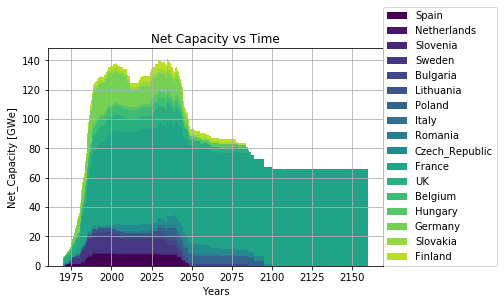

In [233]:
# Display Net Capacity vs Time
from IPython.display import Image
Image(filename='power_plot.png')

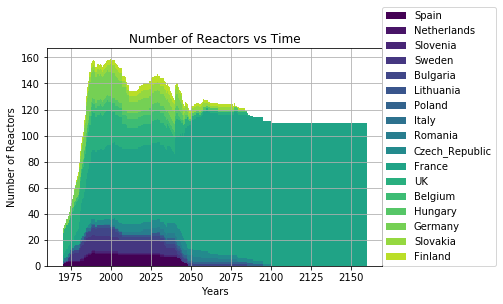

In [197]:
# Display Number of Reactors vs Time
from IPython.display import Image
Image(filename='num_plot.png')

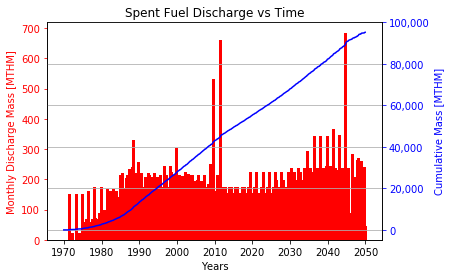

In [198]:
# Display natural U demand  vs Time
from IPython.display import Image
Image(filename='cum_mass_snf_discharge.png')

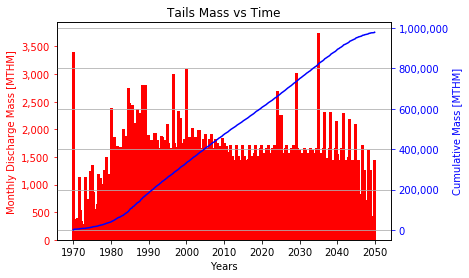

In [199]:
# Display spent fuel vs Time
from IPython.display import Image
Image(filename='tails_tailings.png')

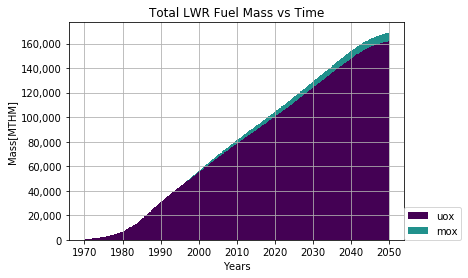

In [200]:
# Display total fuel usage  vs Time
from IPython.display import Image
Image(filename='total_fuel.png')